In [1]:
pip install pygame

Note: you may need to restart the kernel to use updated packages.


In [2]:
# =============================
# Import Library yang Diperlukan
# =============================

In [3]:
import csv
import time
import numpy as np
import pygame
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
# =============================
# Fungsi Membaca CSV Labirin
# =============================

In [5]:
def get_maze(file):
    """
    Membaca file CSV labirin.
    Nilai dalam CSV:
      0 -> ruang kosong
      1 -> dinding
      2 -> titik start
      3 -> titik goal
    """
    start = None
    goal = None
    maze = []
    with open(file, 'r', encoding='utf-8-sig') as f:
        reader = csv.reader(f)
        for i, row in enumerate(reader):
            numeric_row = []
            for j, value in enumerate(row):
                try:
                    num = int(value)
                except ValueError:
                    continue  # Lewati nilai yang tidak bisa dikonversi
                numeric_row.append(num)
                if num == 2:
                    start = (i, j)
                elif num == 3:
                    goal = (i, j)
            maze.append(numeric_row)
    # Jika tiap baris memiliki panjang berbeda, tambahkan dinding (1) untuk padding
    max_len = max(len(r) for r in maze)
    for row in maze:
        if len(row) < max_len:
            row.extend([1]*(max_len - len(row)))
    return maze, start, goal

In [6]:
# =============================
# Menampilkan Labirin Secara Statik
# =============================

In [7]:
def display_maze_static(maze, title='Labirin Asli'):
    maze_arr = np.array(maze)
    cmap = ListedColormap(['white','black','green','red'])
    plt.figure(figsize=(6,6))
    plt.imshow(maze_arr, cmap=cmap, origin='upper')
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

def display_maze_with_path(maze, path, title='Labirin dengan Jalur A*'):
    maze_arr = np.array(maze)
    maze_path = maze_arr.copy()
    # Tandai sel-sel pada jalur optimal dengan nilai 4 (untuk pewarnaan)
    for (i, j) in path:
        if maze_path[i][j] == 0:
            maze_path[i][j] = 4
    cmap = ListedColormap(['white','black','green','red','blue'])
    plt.figure(figsize=(6,6))
    plt.imshow(maze_path, cmap=cmap, origin='upper')
    plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [8]:
# =============================
# Implementasi A* dengan Konsep Wavefront
# =============================

In [9]:
def wavefront_algorithm_animation(maze, goal):
    """
    Melakukan wavefront algorithm dan merekam langkah-langkah eksplorasi.
    wavefront: matriks jarak dari goal.
    exploration_steps: list berisi pasangan (sel, nilai) dalam urutan kunjungan.
    """
    rows, cols = len(maze), len(maze[0])
    wavefront = [[-1 if maze[i][j] != 1 else None for j in range(cols)] for i in range(rows)]
    queue = [goal]
    wavefront[goal[0]][goal[1]] = 0
    exploration_steps = []
    exploration_steps.append((goal, 0))
    while queue:
        x, y = queue.pop(0)
        for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < rows and 0 <= ny < cols:
                if wavefront[nx][ny] == -1 and maze[nx][ny] != 1:
                    wavefront[nx][ny] = wavefront[x][y] + 1
                    queue.append((nx, ny))
                    exploration_steps.append(((nx, ny), wavefront[nx][ny]))
    return wavefront, exploration_steps

def reconstruct_path(wavefront, start, goal):
    """
    Merektruksi jalur optimal dari start ke goal berdasarkan nilai wavefront.
    """
    path = []
    current = start
    while current != goal:
        path.append(current)
        x, y = current
        # Dapatkan tetangga yang valid
        neighbors = [(x+dx, y+dy) for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]]
        neighbors = [n for n in neighbors if 0 <= n[0] < len(wavefront) and 0 <= n[1] < len(wavefront[0])
                     and wavefront[n[0]][n[1]] is not None]
        current = min(neighbors, key=lambda n: wavefront[n[0]][n[1]])
    path.append(goal)
    return path


In [10]:
# =============================
# Fungsi Gambar untuk pygame
# =============================

In [11]:
def draw_maze_with_exploration(screen, maze, cell_size, visited, optimal_path):
    """
    Menggambar labirin dengan pewarnaan:
      - Ruang kosong: putih
      - Dinding: hitam
      - Start: hijau
      - Goal: merah
      - Sel yang telah dikunjungi (eksplorasi): oranye
      - Jalur optimal: biru
    """
    colors = {
        0: (255,255,255),  # ruang kosong
        1: (0,0,0),        # dinding
        2: (0,255,0),      # start
        3: (255,0,0)       # goal
    }
    rows, cols = len(maze), len(maze[0])
    for i in range(rows):
        for j in range(cols):
            rect = pygame.Rect(j * cell_size, i * cell_size, cell_size, cell_size)
            color = colors.get(maze[i][j], (255,255,255))
            pygame.draw.rect(screen, color, rect)
            pygame.draw.rect(screen, (200,200,200), rect, 1)
    # Gambar sel yang telah dikunjungi (eksplorasi)
    for i in range(rows):
        for j in range(cols):
            if visited[i][j]:
                rect = pygame.Rect(j * cell_size, i * cell_size, cell_size, cell_size)
                pygame.draw.rect(screen, (255,165,0), rect)  # oranye
    # Gambar jalur optimal (jika fase path telah aktif)
    for (i, j) in optimal_path:
        if maze[i][j] == 0:
            rect = pygame.Rect(j * cell_size, i * cell_size, cell_size, cell_size)
            pygame.draw.rect(screen, (0,0,255), rect)  # biru

def draw_robot(screen, pos, cell_size):
    """
    Menggambar robot (sebagai persegi kuning) di posisi tertentu.
    """
    if pos is None:
        return
    i, j = pos
    rect = pygame.Rect(j * cell_size, i * cell_size, cell_size, cell_size)
    pygame.draw.rect(screen, (255,255,0), rect)  # kuning

In [12]:
# =============================
# Simulasi Penuh dengan pygame
# =============================

In [13]:
def run_full_simulation(maze, exploration_steps, optimal_path, cell_size=30, exploration_delay=50, path_delay=300):
    """
    Menjalankan simulasi:
      - Fase eksplorasi: menampilkan proses robot menjelajah labirin (sel yang dikunjungi diwarnai oranye).
      - Fase path: setelah eksplorasi selesai, robot mengikuti jalur optimal secara terbalik (kembali ke start).
    """
    pygame.init()
    rows, cols = len(maze), len(maze[0])
    screen = pygame.display.set_mode((cols * cell_size, rows * cell_size))
    pygame.display.set_caption("Simulasi Robot Menjelajah Labirin")
    clock = pygame.time.Clock()
    
    # Matriks untuk menandai sel yang telah dieksplorasi
    visited = [[False for _ in range(cols)] for _ in range(rows)]
    
    step_index = 0
    exploration_phase = True
    path_phase = False
    path_index = 0
    # Untuk fase path, robot akan kembali ke start, jadi kita balik jalur optimal
    reversed_optimal_path = list(reversed(optimal_path))
    
    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                
        screen.fill((255,255,255))
        
        if exploration_phase:
            # Tambahkan sel yang dikunjungi berdasarkan urutan eksplorasi
            if step_index < len(exploration_steps):
                cell, val = exploration_steps[step_index]
                visited[cell[0]][cell[1]] = True
                robot_pos = cell  # posisi robot mengikuti sel yang terakhir dikunjungi
                step_index += 1
            else:
                # Fase eksplorasi selesai, pindah ke fase path
                exploration_phase = False
                path_phase = True
                robot_pos = reversed_optimal_path[0]
                pygame.time.wait(500)  # jeda sebelum memulai fase path
        elif path_phase:
            if path_index < len(reversed_optimal_path):
                robot_pos = reversed_optimal_path[path_index]
                path_index += 1
            else:
                # Setelah robot menyelesaikan jalur optimal, tunggu sebentar dan keluar
                robot_pos = reversed_optimal_path[-1]
                pygame.time.wait(1000)
                running = False
        
        # Gambar labirin dengan penandaan eksplorasi dan jalur optimal (jika sudah dalam fase path)
        draw_maze_with_exploration(screen, maze, cell_size, visited, reversed_optimal_path if path_phase else [])
        draw_robot(screen, robot_pos, cell_size)
        pygame.display.flip()
        
        if exploration_phase:
            pygame.time.wait(exploration_delay)
        elif path_phase:
            pygame.time.wait(path_delay)
        
        clock.tick(60)
    
    pygame.quit()

In [14]:
# =============================
# Main Program
# =============================

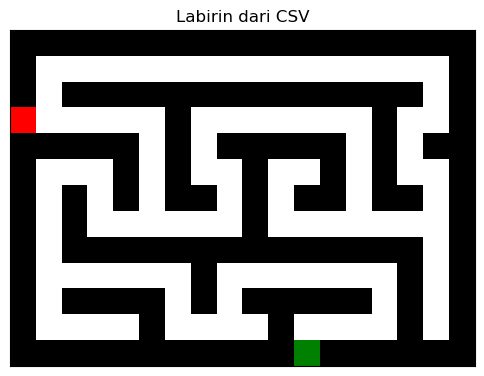

Start: (12, 11), Goal: (3, 0)

Jalur ditemukan:
[(12, 11), (11, 11), (11, 12), (11, 13), (11, 14), (10, 14), (9, 14), (9, 13), (9, 12), (9, 11), (9, 10), (9, 9), (9, 8), (10, 8), (11, 8), (11, 7), (11, 6), (10, 6), (9, 6), (9, 5), (9, 4), (9, 3), (9, 2), (9, 1), (8, 1), (7, 1), (6, 1), (5, 1), (5, 2), (5, 3), (6, 3), (7, 3), (7, 4), (7, 5), (6, 5), (5, 5), (4, 5), (3, 5), (3, 4), (3, 3), (3, 2), (3, 1), (3, 0)]


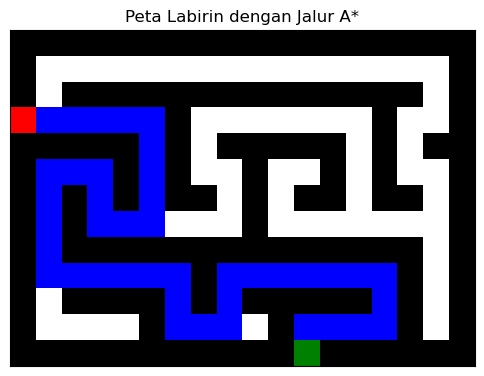

In [15]:
def main():
    # Ganti path berikut sesuai lokasi file CSV labirin Anda secara lokal
    csv_file = 'map 1.csv'
    maze, start, goal = get_maze(csv_file)
    
    # Tampilkan labirin asli secara statik
    display_maze_static(maze, title='Labirin dari CSV')
    
    print(f"Start: {start}, Goal: {goal}")
    
    # Lakukan wavefront algorithm dengan pencatatan langkah eksplorasi
    wavefront, exploration_steps = wavefront_algorithm_animation(maze, goal)
    optimal_path = reconstruct_path(wavefront, start, goal)
    
    print("\nJalur ditemukan:")
    print(optimal_path)
    
    # Tampilkan peta labirin dengan jalur optimal secara statik
    display_maze_with_path(maze, optimal_path, title='Peta Labirin dengan Jalur A*')
    
    # Jalankan simulasi penuh:
    # Fase eksplorasi (robot menjelajah labirin) kemudian robot mengikuti jalur optimal kembali ke start
    run_full_simulation(maze, exploration_steps, optimal_path, cell_size=30, exploration_delay=50, path_delay=300)

if __name__ == '__main__':
    main()